In [1]:
# Tests extract step itself, given known matrices

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.sparse.linalg import lsmr
import time

from scipy.sparse import diags

In [2]:
# retrieve instrument response matrix

file_name = "../sample.pkl"
open_file = open(file_name, "rb")

# response matrix, test commands, 2D detector test response
A_mat, test_cmds, test_response = pickle.load(open_file)
open_file.close()

# kludge: transpose
A_mat = A_mat.T

In [3]:
print(np.shape(A_mat))
print(np.shape(test_cmds))
print(np.shape(test_response))

(20000, 11)
(11, 10)
(11, 100, 200)


In [4]:
# make fake empirical detector readout and noise array

# 2D array of counts on detector
detector_measured_noise = np.random.normal(loc=0,size=(np.shape(test_response)[1],np.shape(test_response)[2]))

detector_variance = 0.1*np.random.normal(loc=0,size=(np.shape(test_response)[1],np.shape(test_response)[2]))

In [39]:
fake_data_1 = detector_measured_noise # just noise
fake_data_2 = np.add(0.1*detector_measured_noise,test_response[5]) # one element of basis set, plus noise
fake_data_3 = np.add(test_response[1],test_response[6]) # two clean elements of basis set
fake_data_4 = np.add(np.add(test_response[1],test_response[6]),0.1*detector_measured_noise) # two elements of basis set, plus noise
fake_data_5 = np.add(test_response[1],3.*test_response[6]) # two clean elements of basis set, different amplitudes
#fake_data_6 = np.add(test_response[0],test_response[10]) # two clean elements of basis set

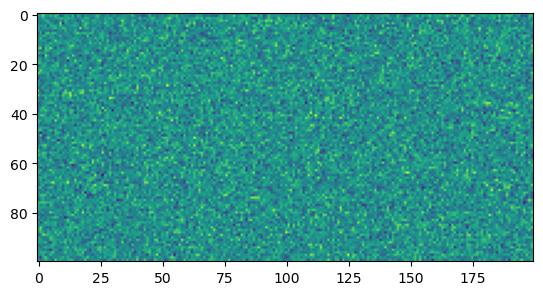

In [6]:
plt.imshow(fake_data_1)
plt.show()

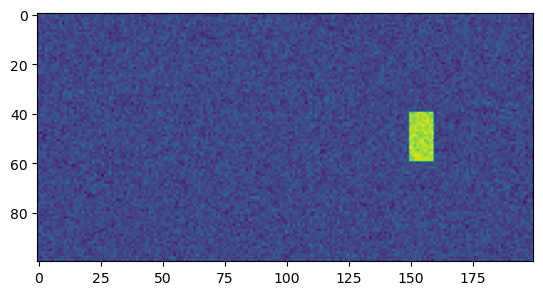

In [7]:
plt.imshow(fake_data_2)
plt.show()

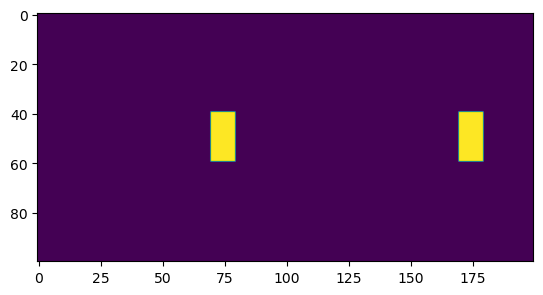

In [8]:
plt.imshow(fake_data_3)
plt.show()

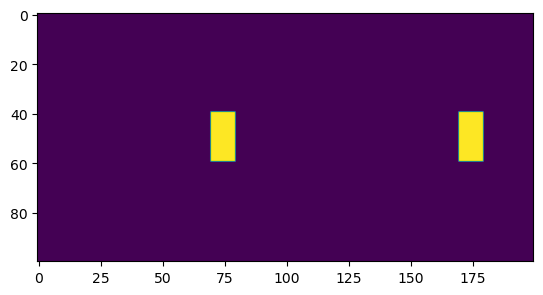

In [9]:
plt.imshow(fake_data_4)
plt.show()

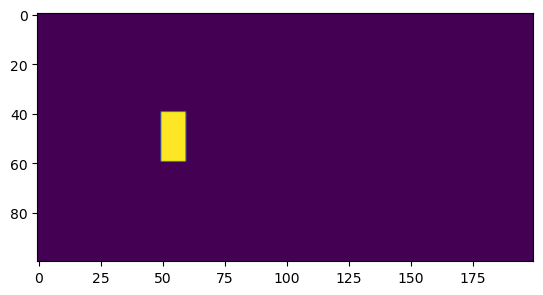

In [10]:
plt.imshow(fake_data_6)
plt.show()

In [40]:
# make weight matrix

w = 1./detector_variance.flatten()
W = diags(w, 0)

In [47]:
# define what we're decomposing

detector_measured = fake_data_5

In [48]:
time_0 = time.time()

A = A_mat

# compute matrices/vectors
ATW = A.T@W # A^T . W

time_1 = time.time()
print("Time:",time_1-time_0)
# -------------------------------------
time_0 = time.time()

#self.report(ATW, 'ATW')
#ATWA = ATW.dot(A) # A^T . W . A
ATWA = ATW@A # A^T . W . A

time_1 = time.time()
print("Time:",time_1-time_0)
# -------------------------------------
time_0 = time.time()

#self.report(ATWA, 'ATWA')
ATWx = ATW@detector_measured.flat

time_1 = time.time()
print("Time:",time_1-time_0)

Time: 0.005629062652587891
Time: 0.0010521411895751953
Time: 0.0005502700805664062


In [49]:
time_0 = time.time()

thresh=3e-4

# compute damping coefficient
ATWAdiag = ATWA.diagonal()
damp = thresh * ATWAdiag.max()

time_1 = time.time()
print("Time:",time_1-time_0)

Time: 0.0003268718719482422


In [50]:
spec_lw, istop, itn, normr, normar, norma, conda, normx = \
          lsmr(ATWA, ATWx,
               damp=damp,
               )

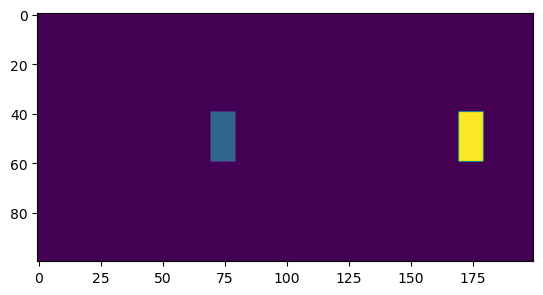

In [51]:
plt.imshow(detector_measured)
plt.show()

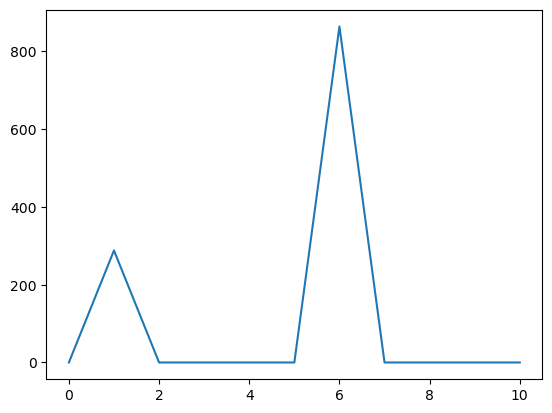

In [52]:
plt.plot(spec_lw)
plt.show()